## Marriage Trends in India

**Import Python libraries and the data**

In [281]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

data = pd.read_csv('marriage_data_india.csv')
display(data.head())

,ID,Marriage_Type,Age_at_Marriage,Gender,Education_Level,Caste_Match,Religion,Parental_Approval,Urban_Rural,Dowry_Exchanged,Marital_Satisfaction,Divorce_Status,Children_Count,Income_Level,Years_Since_Marriage,Spouse_Working,Inter-Caste,Inter-Religion
0,1,Love,23,Male,Graduate,Different,Hindu,No,Urban,No,Medium,Yes,5,Middle,34,No,No,No
1,2,Love,28,Female,School,Same,Hindu,Yes,Rural,Yes,Low,No,3,Middle,42,No,No,Yes
2,3,Arranged,39,Male,Postgraduate,Same,Muslim,Yes,Rural,No,Medium,No,0,High,25,No,No,No
3,4,Arranged,26,Female,School,Different,Hindu,Yes,Urban,Yes,Low,No,0,High,12,No,Yes,No
4,5,Love,32,Female,Graduate,Same,Hindu,Partial,Rural,Yes,Medium,No,1,Middle,41,No,No,Yes


**Check for null values within the entire dataset**

In [282]:
display(data.isna().sum())

ID                      0
Marriage_Type           0
Age_at_Marriage         0
Gender                  0
Education_Level         0
Caste_Match             0
Religion                0
Parental_Approval       0
Urban_Rural             0
Dowry_Exchanged         0
Marital_Satisfaction    0
Divorce_Status          0
Children_Count          0
Income_Level            0
Years_Since_Marriage    0
Spouse_Working          0
Inter-Caste             0
Inter-Religion          0
dtype: int64

**Do some initial cleaning of the data**

In [283]:
data.rename(columns={'Inter-Caste':'Inter_Caste', 'Inter-Religion': 'Inter_Religion'}, inplace=True)
data.drop(columns=['ID'], inplace=True)

**Separate the column labels by numeric and categorical data**

In [284]:
cols_categorical = data.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical Columns:\n{cols_categorical}")

cols_numeric = data.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric Columns:\n{cols_numeric}")

Categorical Columns:
['Marriage_Type', 'Gender', 'Education_Level', 'Caste_Match', 'Religion', 'Parental_Approval', 'Urban_Rural', 'Dowry_Exchanged', 'Marital_Satisfaction', 'Divorce_Status', 'Income_Level', 'Spouse_Working', 'Inter_Caste', 'Inter_Religion']
Numeric Columns:
['Age_at_Marriage', 'Children_Count', 'Years_Since_Marriage']


**Graph the basic counts of the data**

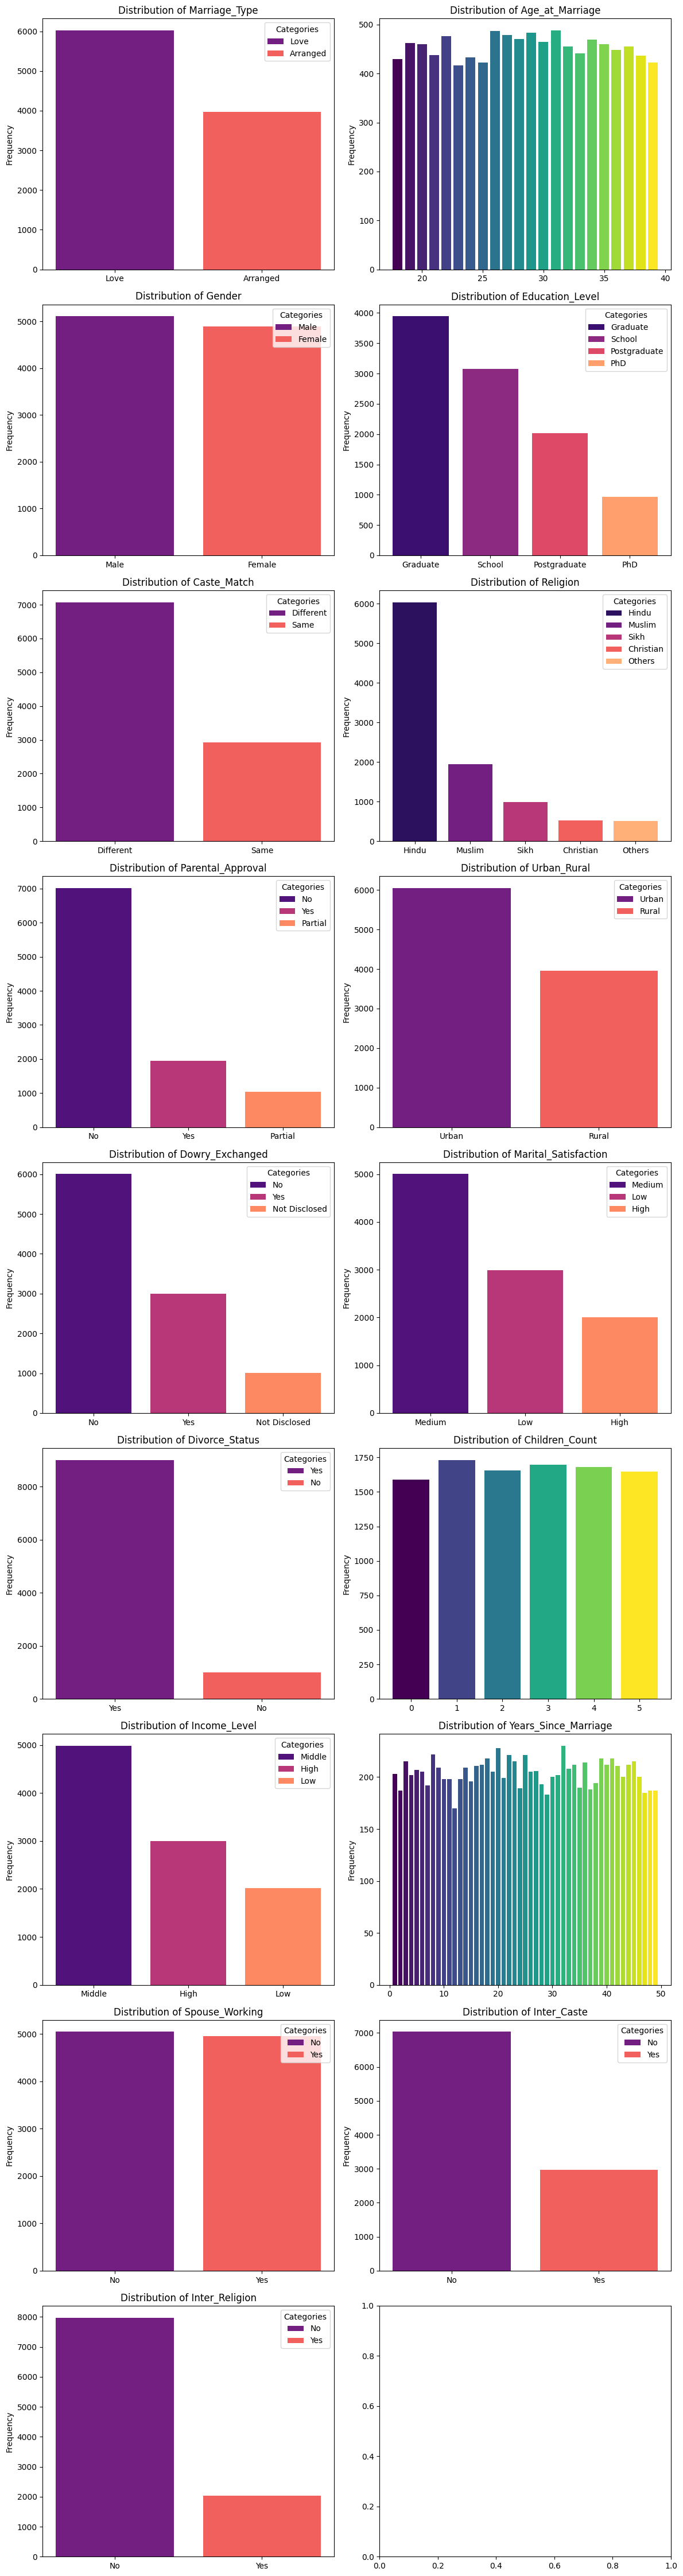

In [285]:
fig, axes = plt.subplots(nrows=(len(data.columns) + 1) // 2, ncols=2, figsize=(12, 5 * ((len(data.columns) + 1) // 2)))
axes = axes.flatten()
for i, col in enumerate(data.columns):
    ax = axes[i]
    x_cats = data[col].unique()
    if col in cols_numeric:
        x_cats = np.sort(x_cats)
        y_counts = data[col].value_counts().sort_index()
        colors = plt.cm.viridis(np.linspace(0, 1, len(y_counts)))
    else:
        y_counts = data[col].value_counts()
        colors = sns.color_palette('magma', len(y_counts))
    ax.bar(x_cats, y_counts, color=colors, label=x_cats)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {col}')
    if not col in cols_numeric:
        ax.legend(x_cats, title='Categories')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'{col}_Distribution.png', bbox_inches=extent)
plt.tight_layout()
plt.savefig('All_Distributions.png')
plt.show()

**Separate the data out to X and y variables**

In [286]:
X = data.drop(columns=['Divorce_Status'])
y = data['Divorce_Status']

**One Hot Encode the categorical columns**

In [287]:
X = pd.get_dummies(X, drop_first=True)
display(X.head())

,Age_at_Marriage,Children_Count,Years_Since_Marriage,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,...,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
0,23,5,34,True,True,False,False,False,False,True,...,True,False,False,False,True,False,True,False,False,False
1,28,3,42,True,False,False,False,True,True,True,...,False,False,True,True,False,False,True,False,False,True
2,39,0,25,False,True,False,True,False,True,False,...,False,False,False,False,True,False,False,False,False,False
3,26,0,12,False,False,False,False,True,False,True,...,True,False,True,True,False,False,False,False,True,False
4,32,1,41,True,False,False,False,False,True,True,...,False,False,True,False,True,False,True,False,False,True


**Label Encode the y vector**

In [288]:
le = LabelEncoder()
y = le.fit_transform(y)

**Use Random Undersampling to balance the data**

In [289]:
print(f"Number of '0' class instances in y: {sum(y==0)}")
print(f"Number of '1' class instances in y: {sum(y==1)}")

random_under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = random_under_sampler.fit_resample(X, y)

print(f"Number of '0' class instances in y after resample: {sum(y_resampled==0)}")
print(f"Number of '1' class instances in y after resample: {sum(y_resampled==1)}")

Number of '0' class instances in y: 8999
Number of '1' class instances in y: 1001
Number of '0' class instances in y after resample: 1001
Number of '1' class instances in y after resample: 1001


**Perform Backwards Elimination to find the most important variables in the dataset**

In [291]:
def backwardElimination(x, y, sl):
    numVars = len(x[0])
    indices = list(range(numVars))
    for i in range(0, numVars):
        obj_OLS = sm.OLS(y, x).fit()
        maxVar = max(obj_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, len(indices)):
                if (obj_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    indices.pop(j)
                    break
    display(obj_OLS.summary())
    x = x[:, 1:]
    indices.pop(0)
    indices = [i - 1 for i in indices]
    return x, indices  

SL = 0.05
X_backe = np.append(arr=np.ones((len(X_resampled),1)), values=X_resampled, axis=1)
X_backe = X_backe.astype('float64')
X_sig = X_backe
X_Modeled, indices = backwardElimination(X_sig, y_resampled, SL)
print(f'Selected Features Indices: {indices}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.285
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           0.000311
Time:                        11:21:54   Log-Likelihood:                -1442.5
No. Observations:                2002   AIC:                             2895.
Df Residuals:                    1997   BIC:                             2923.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4750      0.030     15.609      0.000       0.415       0.535
x1            -0.0129      0.007     -1.967      0.049      -0.026   -3.62e-05
x2             0.0637      0.032      2.002      0.045       0.001       0.126
x3             0.1077      0.030      3.651      0.000       0.050       0.166
x4            -0.0499      0.024     -2.052      0.040      -0.098      -0.002
==============================================================================
Omnibus:                     7350.870   Durbin-Watson:                   0.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.936
Skew:                          -0.001   Prob(JB):                     3.36e-70
Kurtosis:                       1.042   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Selected Features Indices: [1, 20, 21, 23]


**Display the head of the X variable with only the 'important' indices selected**

In [292]:
X_resampled = pd.DataFrame(X_resampled, columns=X.columns[indices].to_list())
X_resampled.head()

,Children_Count,Income_Level_Low,Income_Level_Middle,Inter_Caste_Yes
4110,0,False,True,True
6349,1,True,False,True
3297,3,True,False,False
7949,4,False,True,True
754,5,False,True,True


**Get the numeric columns in the adjusted dataset**

In [293]:
cols_numeric = X_resampled.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric Columns:\n{cols_numeric}")

Numeric Columns:
['Children_Count']


**Use the backwards eliminated data to split the variables**

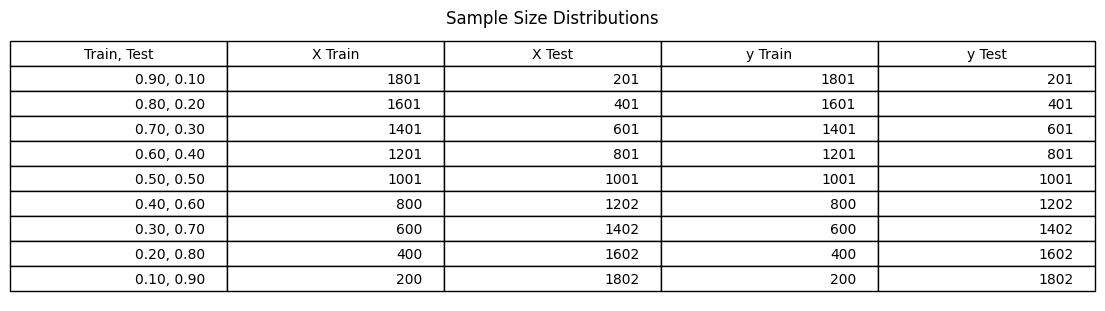

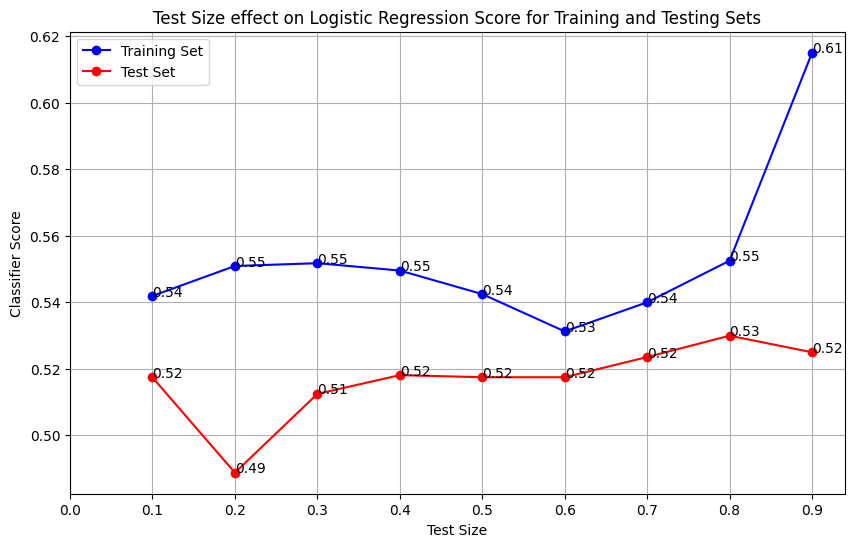

In [294]:
testScores = []
trainScores = []
testSampleSizes = np.arange(0.1, 1.0, 0.1)
tableVals = []
for i in testSampleSizes:
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=i, random_state=42, stratify=y_resampled)
    
    tableVals.append([f'{1-i:.2f}, {i:.2f}', len(X_train), len(X_test), len(y_train), len(y_test)])
    
    scaler = StandardScaler()
    X_train[cols_numeric] = scaler.fit_transform(X_train[cols_numeric])
    X_test[cols_numeric] = scaler.transform(X_test[cols_numeric])
    
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)
    trainScores.append(lr.score(X_train, y_train))    
    testScores.append(lr.score(X_test, y_test))

tableCols = ['Train, Test', 'X Train', 'X Test', 'y Train', 'y Test']    
fig, ax = plt.subplots(figsize=(14,3.5))
ax.set_axis_off()
table = ax.table(cellText=tableVals, colLabels=tableCols, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5) 
ax.title.set_text("Sample Size Distributions")
plt.savefig('sample_size_distributions.png')
plt.show()

plt.figure(figsize=(10, 6))
for i, txt in enumerate(trainScores):
    plt.annotate(round(txt, 2), (np.arange(0.1, 1.0, 0.1)[i], trainScores[i]), fontsize=10)
for i, txt in enumerate(testScores):
    plt.annotate(round(txt, 2), (np.arange(0.1, 1.0, 0.1)[i], testScores[i]), fontsize=10)
plt.plot(np.arange(0.1, 1.0, 0.1), trainScores, marker='o', color='blue', linestyle='-', label='Training Set')
plt.plot(np.arange(0.1, 1.0, 0.1), testScores, marker='o', color='red', linestyle='-', label='Test Set')
plt.title('Test Size effect on Logistic Regression Score for Training and Testing Sets')
plt.xlabel('Test Size')
plt.ylabel('Classifier Score')
plt.xticks(np.arange(0, 1, .1))
plt.savefig('dataset_size_effect_on_score.png')
plt.legend()
plt.grid()
plt.show()

**0.5 looks to be the best train test split we have**

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.8, random_state=42, stratify=y_resampled)

**Use a standard scaler to scale our numeric data**

In [297]:
scaler = StandardScaler()
X_train[cols_numeric] = scaler.fit_transform(X_train[cols_numeric])
X_test[cols_numeric] = scaler.transform(X_test[cols_numeric])

print("X Training Set Head:")
display(X_train.head())

print("X Testing Set Head:")
display(X_test.head())

X Training Set Head:


,Children_Count,Income_Level_Low,Income_Level_Middle,Inter_Caste_Yes
5366,0.321012,False,True,True
3629,-1.470682,False,False,False
8756,1.515474,True,False,True
2686,0.321012,False,True,True
3448,0.321012,False,True,False


X Testing Set Head:


,Children_Count,Income_Level_Low,Income_Level_Middle,Inter_Caste_Yes
6607,0.918243,False,True,False
4811,0.918243,False,True,False
7481,-1.470682,False,False,False
9925,0.321012,False,True,False
3701,0.321012,False,True,False


**Perform PCA on the prepped data**

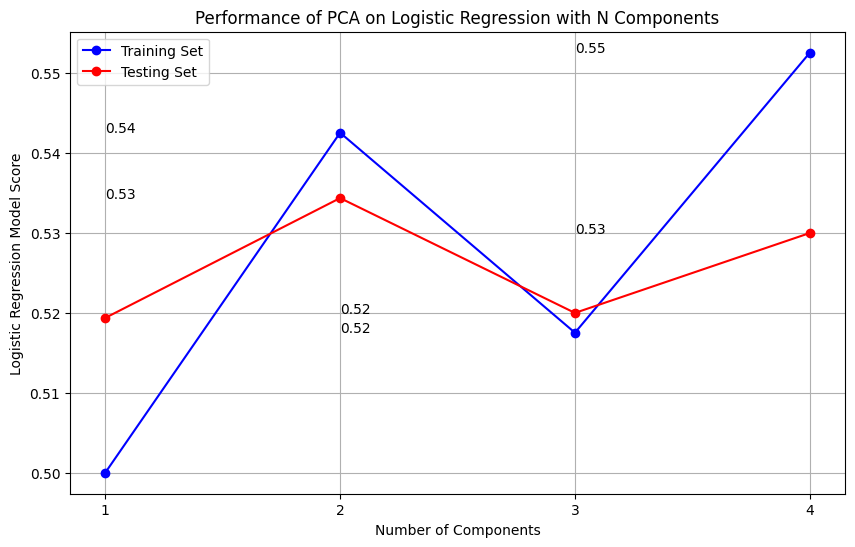

In [298]:
train_scores = []
test_scores = []
upperLimit = len(X_train.columns) + 1
for i in range(1, upperLimit):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    lr = LogisticRegression()
    lr.fit(X_train_pca, y_train)
    train_scores.append(lr.score(X_train_pca, y_train))
    test_scores.append(lr.score(X_test_pca, y_test))


plt.figure(figsize=(10, 6))
for i, txt in enumerate(train_scores):
    plt.annotate(round(txt, 2), (i, train_scores[i]), fontsize=10) 
for i, txt in enumerate(test_scores):
    plt.annotate(round(txt, 2), (i, test_scores[i]), fontsize=10)       
plt.plot(range(1, upperLimit), train_scores, marker='o', color='blue', linestyle='-', label='Training Set')
plt.plot(range(1, upperLimit), test_scores, marker='o', color='red', linestyle='-', label='Testing Set')
plt.title('Performance of PCA on Logistic Regression with N Components')
plt.xlabel('Number of Components')
plt.ylabel('Logistic Regression Model Score')
plt.xticks(range(1, upperLimit))
plt.grid()
plt.savefig('pca_performance.png')
plt.legend()
plt.show()

In [299]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

**Build a reusable method for training and testing models**

In [300]:
def ModelTrainFitAndReport(classifier, classifierName):
    classifier.fit(X_train_pca, y_train)
    y_pred = classifier.predict(X_test_pca)
    print(f"Classification Report for {classifierName} for Testing Set:\n")
    print(classification_report(y_test, y_pred))
    
    return (classifierName, classifier)



**Logistic Regression**

In [301]:
logistic_regression = ModelTrainFitAndReport(LogisticRegression(), "Logistic Regression")

Classification Report for Logistic Regression for Testing Set:

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       801
           1       0.54      0.52      0.53       801

    accuracy                           0.53      1602
   macro avg       0.53      0.53      0.53      1602
weighted avg       0.53      0.53      0.53      1602



**Random Forest**

In [302]:
random_forest = ModelTrainFitAndReport(RandomForestClassifier(), "Random Forest Classifier")

Classification Report for Random Forest Classifier for Testing Set:

              precision    recall  f1-score   support

           0       0.55      0.34      0.42       801
           1       0.52      0.72      0.60       801

    accuracy                           0.53      1602
   macro avg       0.53      0.53      0.51      1602
weighted avg       0.53      0.53      0.51      1602



**Support Vector Classifier**

**RBF Kernel**

In [303]:
rbf_svm = ModelTrainFitAndReport(SVC(kernel='rbf'), "RBF SVM Classifier")

Classification Report for RBF SVM Classifier for Testing Set:

              precision    recall  f1-score   support

           0       0.53      0.49      0.51       801
           1       0.53      0.57      0.55       801

    accuracy                           0.53      1602
   macro avg       0.53      0.53      0.53      1602
weighted avg       0.53      0.53      0.53      1602



**Poly Kernel**

In [304]:
poly_svm = ModelTrainFitAndReport(SVC(kernel='poly'), "Polynomial SVM Classifier")

Classification Report for Polynomial SVM Classifier for Testing Set:

              precision    recall  f1-score   support

           0       0.51      0.38      0.44       801
           1       0.50      0.63      0.56       801

    accuracy                           0.50      1602
   macro avg       0.51      0.50      0.50      1602
weighted avg       0.51      0.50      0.50      1602



**Decision Tree Classifier**

In [305]:
decision_tree = ModelTrainFitAndReport(DecisionTreeClassifier(criterion='entropy'), "Decision Tree Classifier")

Classification Report for Decision Tree Classifier for Testing Set:

              precision    recall  f1-score   support

           0       0.52      0.44      0.48       801
           1       0.52      0.60      0.56       801

    accuracy                           0.52      1602
   macro avg       0.52      0.52      0.52      1602
weighted avg       0.52      0.52      0.52      1602



**Naive Bayes Classifier**

In [306]:
naive_bayes = ModelTrainFitAndReport(GaussianNB(), "Naive Bayes Classifier")

Classification Report for Naive Bayes Classifier for Testing Set:

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       801
           1       0.53      0.51      0.52       801

    accuracy                           0.53      1602
   macro avg       0.53      0.53      0.53      1602
weighted avg       0.53      0.53      0.53      1602



**Adaptive Boost Classifier**

In [307]:
ada_boost = ModelTrainFitAndReport(AdaBoostClassifier(), "AdaBoost Classifier")

Classification Report for AdaBoost Classifier for Testing Set:

              precision    recall  f1-score   support

           0       0.56      0.40      0.47       801
           1       0.53      0.69      0.60       801

    accuracy                           0.54      1602
   macro avg       0.55      0.54      0.53      1602
weighted avg       0.55      0.54      0.53      1602



**Gradient Boost Classifier**

In [308]:
gradient_boost = ModelTrainFitAndReport(GradientBoostingClassifier(), "Gradient Boosting Classifier")

Classification Report for Gradient Boosting Classifier for Testing Set:

              precision    recall  f1-score   support

           0       0.55      0.35      0.43       801
           1       0.52      0.71      0.60       801

    accuracy                           0.53      1602
   macro avg       0.53      0.53      0.51      1602
weighted avg       0.53      0.53      0.51      1602



**$k$-Nearest Neighbors Classifier**

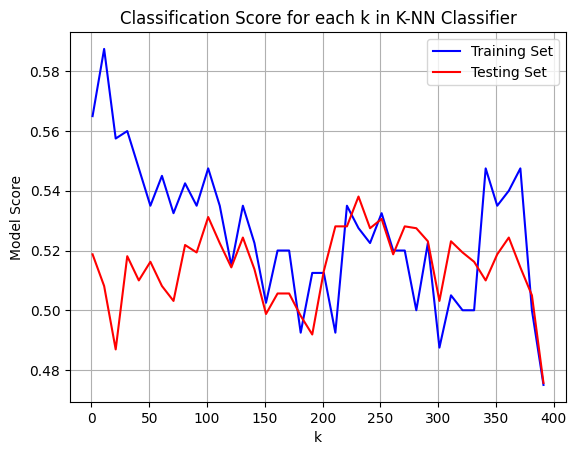

Best k: 24 at 0.5380774032459426
Classification Report for k-NN Classifier for Testing Set:

              precision    recall  f1-score   support

           0       0.50      0.55      0.53       801
           1       0.50      0.45      0.48       801

    accuracy                           0.50      1602
   macro avg       0.50      0.50      0.50      1602
weighted avg       0.50      0.50      0.50      1602



In [309]:
train_scores = []
test_scores = []
ks = np.arange(1, len(X_train), 10)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    train_scores.append(knn.score(X_train_pca, y_train))
    test_scores.append(knn.score(X_test_pca, y_test))

plt.plot(ks, train_scores, color='blue', label='Training Set')
plt.plot(ks, test_scores, color='red', label='Testing Set')
plt.xlabel('k')
plt.ylabel('Model Score')
plt.title('Classification Score for each k in K-NN Classifier')
plt.grid(True)
plt.legend()
plt.savefig('knn_scores.png')
plt.show()

best_k_index = np.argmax(test_scores) + 1
print(f"Best k: {best_k_index} at {test_scores[best_k_index-1]}")
knn = ModelTrainFitAndReport(KNeighborsClassifier(n_neighbors=best_k_index), "k-NN Classifier")

**Voting Classifier**

In [310]:
classifiers = [random_forest, decision_tree, logistic_regression, knn, poly_svm, rbf_svm, naive_bayes, ada_boost, gradient_boost]
voting_classifier = ModelTrainFitAndReport(VotingClassifier(estimators=classifiers, voting='hard'), "Voting Classifier")

Classification Report for Voting Classifier for Testing Set:

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       801
           1       0.53      0.55      0.54       801

    accuracy                           0.53      1602
   macro avg       0.53      0.53      0.53      1602
weighted avg       0.53      0.53      0.53      1602

